In [171]:
import json
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

## Load LabelMatch labels

In [3]:
# extracted gold labels 
vg_ix2label = pickle.load(open("flickr30ke_labelmatch/ix2label.pkl", "rb"))
vg_ix2label[:5]

[14423, 14425, 14426, 14428, 14432]

In [4]:
# faster rcnn distribution for each element in the labelmatch subset
ix2cls_distr = pickle.load(open("flickr30ke_labelmatch/ix2cls_distr.pkl", "rb"))

# percentage of agreement bw extracted gold labels and faster r-cnn predictions in labelmatch
cnt = 0
for ix, cls_distr in ix2cls_distr.items():
    cnt += (np.argmax(ix2cls_distr[ix]) == vg_ix2label[ix])
cnt / len(ix2cls_distr)

0.3806477015454277

## Load F30kE dataset

In [18]:
import os, sys
sys.path.append("../volta")
from volta.datasets.flickr30ke_ablation_dataset import get_annotations, get_sentence_data

In [17]:
with open("/science/image/nlp-datasets/emanuele/data/flickr30k_entities/val.txt", "r") as f:
    images = f.read().splitlines()

entries = []
for img in images:
    annotation = get_annotations(os.path.join("/science/image/nlp-datasets/emanuele/data/flickr30k_entities/Annotations", img + ".xml"))
    sentences = get_sentence_data(os.path.join("/science/image/nlp-datasets/emanuele/data/flickr30k_entities/Sentences", img + ".txt"))
    for i, sent in enumerate(sentences):
        for phrase in sent["phrases"]:
            if str(phrase["phrase_id"]) in annotation["boxes"].keys():
                entries.append(
                    {
                        "caption": phrase["phrase"],
                        "first_word_index": phrase["first_word_index"],
                        "sent_id": int(phrase["phrase_id"]),
                        "image_id": int(img),
                        "refBoxes": annotation["boxes"][str(phrase["phrase_id"])],
                        "sentence": sent["sentence"],
                        "type": phrase["phrase_type"],
                    }
                )
len(entries)

14433

## Compute phrase type mappings

In [26]:
# some phrases might be associated to multiple types in the dataset
# we just select the first type (more specific) when we have 2
phrase2type = dict()
for e in entries:
    phrase2type[e['caption']] = e['type'][0]
len(phrase2type)

6257

In [32]:
# load label for each phrase
phr2label = pickle.load(open("flickr30ke_labelmatch/phr2label.pkl", "rb"))
print(len(phr2label))

3235


In [34]:
# map each label to its phrase types
# we just select the first type (more specific) when we have 2
label2types = defaultdict(set)
for e in entries:
    try:
        label2types[phr2label[e['caption']]].add(e['type'][0])
    except:
        pass
len(label2types)

716

In [45]:
# when multiple phrase types are present, the second is a more generic type, either "scene" or "other"
# we just select the first type (more specific) when we have 2
label2type = dict()
for label, types in label2types.items():
    if len(types) == 1:
        label2type[label] = list(types)[0]
    elif ('scene' in types) or ('other' in types):
        t = set(types)
        try:
            t.remove('scene')
        except:
            t.remove('other')
        label2type[label] = list(types)[0]

## Compute confusion matrix

### Mismatching labels 

In [ ]:
# get gold and predicted labels for each datapoint in labelmatch
true_pred_pairs = []
for ix, cls_distr in ix2cls_distr.items():
    true_cls = vg_ix2label[ix]
    pred_cls = np.argmax(ix2cls_distr[ix])
    true_pred_pairs.append((true_cls, pred_cls))
len(true_pred_pairs)

In [59]:
# get gold and predicted labels for datapoints in labelmatch whose predicted label != gold label (mismatches)
true_pred_mis_pairs = []
for ix, cls_distr in ix2cls_distr.items():
    true_cls = vg_ix2label[ix]
    pred_cls = np.argmax(ix2cls_distr[ix])
    if true_cls != pred_cls:
        true_pred_mis_pairs.append((true_cls, pred_cls))
len(true_pred_mis_pairs)

6292

In [159]:
# map labels into phrase types for the mismatched datapoints
true_pred_type_mis_pairs = []
for t, p in true_pred_mis_pairs:
    true_pred_type_mis_pairs.append((label2type.get(t, "other"), label2type.get(p, "other")))
len(true_pred_type_mis_pairs)

6292

In [162]:
# get confusion matrix of mismatches
y_actu = pd.Series([e[0] for e in true_pred_type_mis_pairs], name='Gold')
y_pred = pd.Series([e[1] for e in true_pred_type_mis_pairs], name='Silver')
df_mis = pd.crosstab(y_actu, y_pred).drop('instruments')
df_mis

Silver,animals,bodyparts,clothing,other,people,scene,vehicles
Gold,,,,,,,
animals,127,3,4,17,15,12,0
bodyparts,3,113,29,100,28,18,1
clothing,8,59,264,132,173,159,4
other,16,54,66,892,147,194,36
people,8,34,54,152,2314,82,10
scene,10,2,76,280,105,320,17
vehicles,0,0,0,30,13,15,95


### Matching labels

In [149]:
# get gold and predicted labels for datapoints in labelmatch whose predicted label == gold label (matches)
true_pred_ok_pairs = []
for ix, cls_distr in ix2cls_distr.items():
    true_cls = vg_ix2label[ix]
    pred_cls = np.argmax(ix2cls_distr[ix])
    if true_cls == pred_cls:
        true_pred_ok_pairs.append((true_cls, pred_cls))
len(true_pred_ok_pairs)

3867

In [151]:
# map labels into phrase types for the mismatched datapoints
true_pred_type_ok_pairs = []
for t, p in true_pred_ok_pairs:
    if t in label2type:
        true_pred_type_ok_pairs.append((label2type[t], label2type[p]))
len(true_pred_type_ok_pairs)

3867

In [152]:
# get confusion matrix of matches
y_actu = pd.Series([e[0] for e in true_pred_type_ok_pairs], name='Gold')
y_pred = pd.Series([e[1] for e in true_pred_type_ok_pairs], name='Silver')
df_ok = pd.crosstab(y_actu, y_pred)
df_ok

### Ratio of mismatched over mismatched+matched

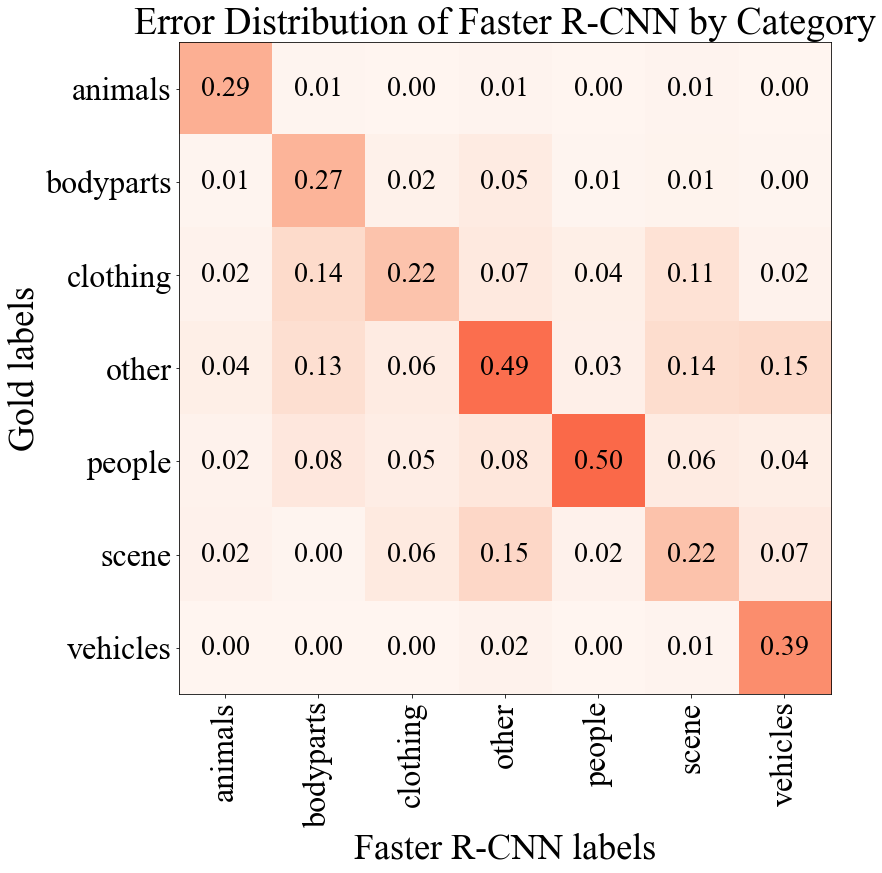

In [180]:
df_confusion = df_mis / (df_mis + df_ok).sum(1)

f, ax = plt.subplots(figsize=(12,12))

ax.imshow(df_confusion, cmap='Reds', vmin=0, vmax=1)

names = list(df_confusion.index)
ax.set_xticklabels([''] + names, rotation=90, fontsize=32)
ax.set_yticklabels([''] + names, rotation=0, fontsize=32)
ax.set_xlabel("Faster R-CNN labels", fontsize=36)
ax.set_ylabel("Gold labels", fontsize=36)
ax.set_title("Error Distribution of Faster R-CNN by Category", fontsize=38)

for i in range(len(names)):
    for j in range(len(names)):
        text = ax.text(j, i, '%.2f' % df_confusion.iloc[i, j], ha="center", va="center", color="k", fontsize=28)
        
f.savefig("figures/confusion_all_faster_labelmatch.pdf", bbox_inches="tight")